In [1]:
using RCall, Compat, Random, Distributions, Plots, DifferentialEquations

R"library(kdevine)"

function f_solve(f_deriv, initial, tspan, parameters)
    prob = ODEProblem(f_deriv, initial, tspan, parameters)
    sol = solve(prob)
    return sol
end

function f_sample_solve_uniform(num_samples, population_sample, times_solve, tspan, f_solve, f_deriv, bounds, initial)
    n_params = size(bounds)[1]
    samples = zeros((num_samples, n_params))
    for i = 1:n_params
        samples[:, i] = rand(Uniform(bounds[i, 1], bounds[i, 2]), num_samples)
    end
    mOutputs = zeros((num_samples, length(population_sample)))
    for i in 1:num_samples
        sol = f_solve(f_deriv, initial, tspan, samples[i, :]);
        for j = 1:length(population_sample)
           mOutputs[i, j] = sol(times_solve[j], idxs=population_sample[j])
        end
    end
    return mOutputs
end

function f_estimate_kdevine(mOutputs)
    @rput mOutputs
    R"fit <- kdevine(mOutputs)"
end

function dkdevine(params)
    @rput params
    R"z <- dkdevine(params, fit)"
    @rget z
    return z
end


R version 3.4.2 (2017-09-28) -- "Short Summer"
Copyright (C) 2017 The R Foundation for Statistical Computing
Platform: x86_64-w64-mingw32/x64 (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.



┌ Warning: RCall.jl: Warning: package 'kdevine' was built under R version 3.4.4
│ The kdevine package is no longer actively developed. Consider using 
│    - the 'kde1d' package for marginal estimation, 
│    - the functions vine() and vinecop() from the 'rvinecopulib' 
│      package as replacements for kdevine() and kdevincop().
└ @ RCall C:\Users\bclamber\.julia\packages\RCall\ffM0W\src\io.jl:113


dkdevine (generic function with 1 method)

## Michaelis-Menten kinetics

In [7]:
function deriv_michaelis_menten(dydt, y, p, t)
    k_f = p[1]
    k_r = p[2]
    k_cat = p[3]
    dydt[1] = -k_f * y[1] * y[2] + k_r * y[3] + k_cat * y[3]
    dydt[2] = -k_f * y[1] * y[2] + k_r * y[3]
    dydt[3] = k_f * y[1] * y[2] - k_r * y[3] - k_cat * y[3]
    dydt[4] = k_cat * y[3]
end

mBounds = [[0.2 15]; [0.2 2]; [0.5 3]];

tspan = (0.0, 10.0)
initial = [4.0; 8.0; 0.0; 0.0];

mOutputs = @time f_sample_solve_uniform(10000, [2, 1], [1, 2], tspan, f_solve, deriv_michaelis_menten, mBounds, initial);

@time f_estimate_kdevine(mOutputs)
@time dkdevine([2, 3])

  5.121227 seconds (14.96 M allocations: 1.192 GiB, 4.32% gc time)
 10.749856 seconds (81 allocations: 2.375 KiB)
  0.005762 seconds (97 allocations: 3.031 KiB)


0.02661923219778402

In [286]:
function f_step_bounds(vCurrent, bounds, sigma)
    vProposed = zeros(size(bounds)[1])
    for i = 1:length(vProposed)
        temp = (rand(Normal(vCurrent[i] - bounds[i, 1], sigma[i]), 1)[1] % (bounds[i, 2] - bounds[i, 1]))
        if temp < 0
            temp += bounds[i, 2]
        else
            temp += bounds[i, 1]
        end
        vProposed[i] = temp
    end
    return vProposed
end

f_step_bounds (generic function with 1 method)

In [342]:
function f_mcmc_uniform(num_samples, dist_target, f_dkdevine, sigma, population_sample, times_solve, tspan, f_solve, f_deriv, bounds, initial)
    mInputs = zeros((num_samples, size(bounds)[1]))
    mOutputs = zeros((num_samples, length(population_sample)))
    vOutputs_temp = zeros(length(population_sample))
    # initial points
    mInputs[1, :] = f_step_bounds(mean(bounds, dims=2), bounds, sigma)
    for j = 1:length(population_sample)
        sol = f_solve(f_deriv, initial, tspan, mInputs[1, :]);
        mOutputs[1, j] = sol(times_solve[j], idxs=population_sample[j])
    end
    log_pdf_current = logpdf(dist_target, mOutputs[1, :])
    # MCMC
    for i = 2:num_samples
        vProposed = f_step_bounds(mInputs[i - 1, :], bounds, sigma)
        sol = f_solve(f_deriv, initial, tspan, vProposed);
        for j = 1:length(population_sample)
            vOutputs_temp[j] = sol(times_solve[j], idxs=population_sample[j]);
        end
        log_r = ((logpdf(dist_target, vOutputs_temp) + log(f_dkdevine(mOutputs[i - 1, :]))) -
                 (logpdf(dist_target, mOutputs[i - 1, :]) + log(f_dkdevine(vOutputs_temp))))
        if log_r > log(rand(Uniform(), 1)[1])
            mInputs[i, :] = vProposed
            mOutputs[i, :] = vOutputs_temp
        else
            mInputs[i, :] = mInputs[i - 1, :]
            mOutputs[i, :] = mOutputs[i - 1, :]
        end
    end
    return Dict("inputs" => mInputs, "outputs" => mOutputs)
end

f_mcmc_uniform (generic function with 1 method)

In [348]:
d = MvNormal([2.8, 1.0], [[0.02 -0.01]; [-0.01 0.02]]);
temp = @time f_mcmc_uniform(5000, d, dkdevine, [1, 0.1, 0.1], [2, 1], [1, 2], tspan, f_solve, deriv_michaelis_menten, mBounds, initial)

120.027594 seconds (6.61 M allocations: 514.938 MiB, 0.15% gc time)


Dict{String,Array{Float64,2}} with 2 entries:
  "outputs" => [0.214806 3.58305; 0.277977 3.58139; … ; 2.97032 1.02396; 2.9703…
  "inputs"  => [8.45945 1.15066 1.79301; 7.1516 1.24292 1.82323; … ; 2.65745 1.…

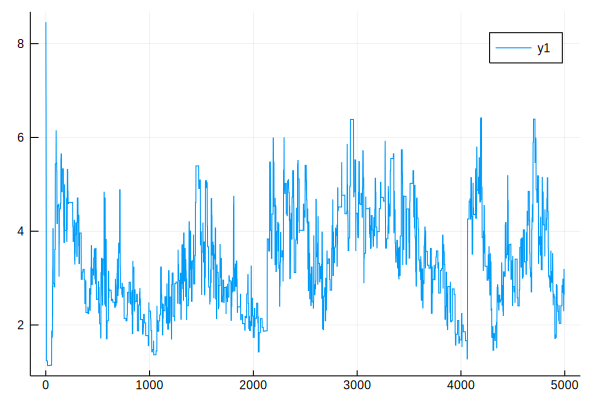

In [349]:
plot(temp["inputs"][:, 1])